In [1]:
# logging 
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [2]:
# environment setup
import gym
# noinspection PyUnresolvedReferences
import gym_maze

maze = gym.make('Maze4-v0')
print("This is how maze looks like")
situation = maze.reset()
print(type(situation))
print(situation)
maze.render()

This is how maze looks like
<class 'tuple'>
('1', '1', '0', '0', '1', '0', '1', '1')

■ ■ ■ ■ ■ ■ ■ ■
■ □ □ ■ A □ $ ■
■ ■ □ □ ■ □ □ ■
■ ■ □ ■ □ □ ■ ■
■ □ □ □ □ □ □ ■
■ ■ □ ■ □ □ □ ■
■ □ □ □ □ ■ □ ■
■ ■ ■ ■ ■ ■ ■ ■


In [3]:
from lcs.agents.xncs import XNCS, Configuration

def cl_accuracy(cl, cfg):
     if cl.error < cfg.epsilon_0:
        return 1
     else:
        return cfg.alpha * pow(1/(cl.error * cfg.epsilon_0), cfg.v)
            
def fraction_accuracy(xncs):
    action_sets_percentages = []
    for action in range(xncs.cfg.number_of_actions):
        action_set = xncs.population.generate_action_set(action)
        total_accuracy = 0
        most_numerous = action_set[0]
        for cl in action_set:
            total_accuracy += cl_accuracy(cl, xncs.cfg)
            if cl.numerosity > most_numerous.numerosity:
                most_numerous = cl
        action_sets_percentages.append(cl_accuracy(most_numerous, xncs.cfg) / total_accuracy)
    return sum(action_sets_percentages) / xncs.cfg.number_of_actions

def specificity(xncs, population):
    total_specificity = 0
    for cl in population:
        total_specificity += pow(2, cl.wildcard_number)
    return total_specificity / xncs.population.numerosity

def xcs_maze_metrics(xncs: XNCS, environment):
    return {
        'numerosity': xncs.population.numerosity,
        'population': len(xncs.population),
        'average_specificity': specificity(xncs, xncs.population),
        'fraction_accuracy': fraction_accuracy(xncs)
    }

In [4]:
cfg = Configuration(number_of_actions=8,
                    max_population=1800,
                    learning_rate=0.2,
                    mutation_chance=0.08,
                    chi=0.8,
                    ga_threshold=25,
                    deletion_threshold=25,
                    delta=0.1,
                    initial_error=0.01,
                    metrics_trial_frequency=50,
                    covering_wildcard_chance = 0.9,
                    user_metrics_collector_fcn=xcs_maze_metrics,
                    lmc=10,
                    lem=200)

In [5]:
agent = XNCS(cfg)
explore_population, explore_metrics = agent.explore(maze, 1000, False)

INFO:lcs.agents.Agent:{'trial': 0, 'steps_in_trial': 50, 'reward': [5.866316727135972e-40, 6.528396107324103e-40, 2.2412305130291682e-40, 6.4976746116082634e-40, 6.715954838795384e-40, 7.169457359119906e-40, 7.707780995223417e-40, 1.8566390876556275e-40], 'numerosity': 79, 'population': 71, 'average_specificity': 2.569620253164557, 'fraction_accuracy': 0.13194444444444445}
INFO:lcs.agents.Agent:{'trial': 100, 'steps_in_trial': 1, 'reward': [523.5880471397604, 308.1288815753598, 22.730629781713585, 16.96870964357394, 18.009451548156274, 27.634566257398756, 24.024463380046825, 24.58137221299023], 'numerosity': 327, 'population': 208, 'average_specificity': 2.1131498470948014, 'fraction_accuracy': 0.017857142857716148}
INFO:lcs.agents.Agent:{'trial': 200, 'steps_in_trial': 50, 'reward': [4.5263501736005765, 21.281661093155314, 6.186356811052515, 11.779310654756094, 5.684496006849906, 8.325044723423478, 10.067241669272596, 5.980053399547474], 'numerosity': 364, 'population': 215, 'average_

In [6]:
for cl in explore_population:
    print(str(cl))

Cond:9#11100# - Act:0 - Num:1 [fit: 0.000, exp: 349.00, pred: 361.607]
Cond:9111#00# - Act:1 - Num:3 [fit: 0.000, exp: 255.00, pred: 271.768]
Cond:#11#1000 - Act:2 - Num:2 [fit: 0.000, exp: 105.00, pred: 245.590]
Cond:911#1000 - Act:3 - Num:2 [fit: 0.000, exp: 49.00, pred: 203.800]
Cond:#1#110#0 - Act:4 - Num:3 [fit: 0.000, exp: 65.00, pred: 219.707]
Cond:911110## - Act:5 - Num:3 [fit: 0.000, exp: 62.00, pred: 235.261]
Cond:9#11##00 - Act:6 - Num:3 [fit: 0.000, exp: 68.00, pred: 209.566]
Cond:#11###00 - Act:7 - Num:2 [fit: 0.000, exp: 238.00, pred: 220.730]
Cond:1#900101 - Act:0 - Num:3 [fit: 0.000, exp: 105.00, pred: 304.887]
Cond:#19#0101 - Act:1 - Num:3 [fit: 0.000, exp: 83.00, pred: 207.658]
Cond:11#00101 - Act:2 - Num:1 [fit: 0.000, exp: 252.00, pred: 287.370]
Cond:111001#1 - Act:3 - Num:3 [fit: 0.000, exp: 180.00, pred: 190.237]
Cond:##900#01 - Act:4 - Num:2 [fit: 0.009, exp: 144.00, pred: 200.013]
Cond:1##0010# - Act:5 - Num:3 [fit: 0.000, exp: 124.00, pred: 194.150]
Cond:#19001

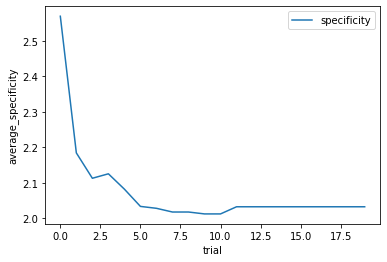

In [7]:
import pandas as pd
import numpy as np

df = pd.DataFrame(metric["average_specificity"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("average_specificity")
ax.legend(["specificity"])


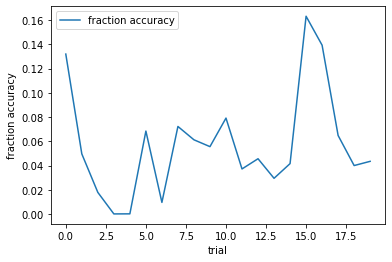

In [8]:
df = pd.DataFrame(metric["fraction_accuracy"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("fraction accuracy")
ax.legend(["fraction accuracy"])


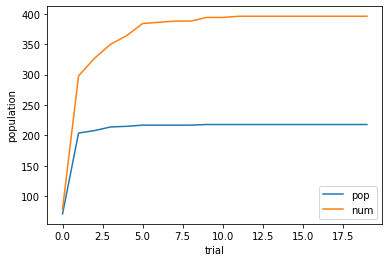

In [9]:

df = pd.DataFrame(zip([metric["population"] for metric in explore_metrics], [metric["numerosity"] for metric in explore_metrics]))
ax = df.plot()
ax.set_xlabel("trial")
ax.set_ylabel("population")
ax.legend(["pop", "num"])

steps_averaged = []


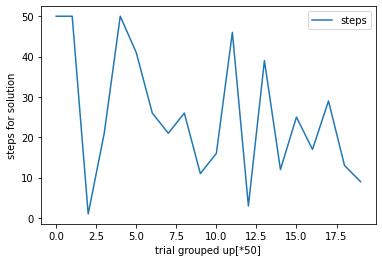

In [10]:


xf = [metric["steps_in_trial"] for metric in explore_metrics]
temp_df = np.array_split(xf, 20)
for i in range(len(temp_df)):
    temp_df[i] = np.mean(temp_df[i]) 
df = pd.DataFrame(temp_df)
# df = pd.DataFrame(metric["steps_in_trial"] for metric in explore_metrics)
ax = df.plot()
ax.set_xlabel("trial grouped up[*50]")
ax.set_ylabel("steps for solution")
ax.legend(["steps"])
